<a href="https://colab.research.google.com/github/leoclementliao/m5_colab/blob/master/s1b_baseline_divide_itemID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
% cp -r '/content/drive/My Drive/Colab Notebooks/kaggle_M5/data' '/content'
! unzip '/content/data/m5-forecasting-accuracy.zip' -d '/content/m5-forecasting-accuracy'
!ls

Archive:  /content/data/m5-forecasting-accuracy.zip
  inflating: /content/m5-forecasting-accuracy/calendar.csv  
  inflating: /content/m5-forecasting-accuracy/sales_train_validation.csv  
  inflating: /content/m5-forecasting-accuracy/sample_submission.csv  
  inflating: /content/m5-forecasting-accuracy/sell_prices.csv  
data  drive  m5-forecasting-accuracy  sample_data


In [0]:
INPUT_DIR = '/content/m5-forecasting-accuracy'
OUTPUT_DIR = '/content/drive/My Drive/Colab Notebooks/kaggle_M5/submission/submission_1b_lgb.csv'

In [7]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import sys
import lightgbm as lgb
from datetime import datetime, timedelta


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def create_train_data(train_start=750,test_start=1800,is_train=True):
    ## Basic parameter
    PRICE_DTYPES = {'store_id':'category', 'item_id':'category', 'wm_yr_wk':'int16',
                  'sell_price':'float32'}
    CAL_DTYPES = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
                "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
                "month": "int16", "year": "int16", "snap_CA": "uint8", 'snap_TX': 'uint8', 'snap_WI': 'uint8'}
    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {col: 'category' for col in catcols}
    SALE_DTYPES.update({col: 'float32' for col in numcols})

    ## Read data with specific format
    price_data = pd.read_csv(f"{INPUT_DIR}/sell_prices.csv",dtype=PRICE_DTYPES).pipe(reduce_mem_usage)
    cal_data = pd.read_csv(f"{INPUT_DIR}/calendar.csv",dtype=CAL_DTYPES).pipe(reduce_mem_usage)
    sale_data = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv",dtype=SALE_DTYPES,usecols=catcols+numcols).pipe(reduce_mem_usage)

    ## category encode to int16
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            price_data[col] -= price_data[col].min()

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()

    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    ## Extension of days to test area
    if not is_train:
        for day in range(1913+1, 1913+2*28+1):
            sale_data[f'd_{day}'] = np.nan

    ## Melt day information to one column
    sale_data = pd.melt(sale_data,
                        id_vars = catcols,
                        value_vars = [col for col in sale_data.columns if col.startswith('d_')],
                        var_name = 'd',
                        value_name = 'sales'
                       )
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on=['store_id', 'item_id', 'wm_yr_wk'], copy=False)
    
    return sale_data

In [0]:
def create_feature(sale_data, is_train=True, day=None):

    ## week lag (7 days), month lag (28 dyas)
    lags = [7, 28]
    lag_cols = [f'lag_{lag}' for lag in lags]

    ## shift lag data
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[['id', 'sales']].groupby('id')['sales'].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = \
            sale_data.loc[sale_data.date ==day-timedelta(days=lag), 'sales'].values  

    ## windows average
    wins = [7, 28]
    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = \
                sale_data[["id", lag_col]].groupby("id")[lag_col]\
                .transform(lambda x : x.rolling(win).mean())
    else:
        for win in wins:
            for lag in lags:
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"rmean_{lag}_{win}"] = df_window_grouped.sales.values   

    ## Get time related features {feat_name: func}
    date_features = {
                "wday": "weekday",
                "week": "weekofyear",
                "month": "month",
                "quarter": "quarter",
                "year": "year",
                "mday": "day",
            }
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")

    ## Divide item_id to 7 departments
    dept_list = ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 
                 'FOODS_1', 'FOODS_2', 'FOODS_3'] # the order is fixed
    for i, id_name in enumerate(dept_list):
        sale_data[id_name] = 0
        sale_data.loc[sale_data.dept_id==i, id_name] = sale_data.loc[sale_data.dept_id==i, 'item_id']

    return sale_data        

In [11]:
sale_data = create_train_data(train_start=350,is_train=True)
sale_data = create_feature(sale_data).pipe(reduce_mem_usage)

Mem. usage decreased to 45.77 Mb (22.2% reduction)
Mem. usage decreased to  0.06 Mb (6.0% reduction)
Mem. usage decreased to 92.77 Mb (49.5% reduction)
Mem. usage decreased to 3069.20 Mb (41.5% reduction)


In [12]:
sale_data.dropna(inplace=True)
print(sale_data.columns)

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7', 'lag_28',
       'rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28', 'week',
       'quarter', 'mday', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1',
       'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3'],
      dtype='object')


In [0]:
drop_cols = ['id', 'item_id', 'date', 'sales', 'd', 'wm_yr_wk', 'weekday']
dept_list = ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2',
             'FOODS_1', 'FOODS_2', 'FOODS_3']
             
train_cols=['dept_id', 'store_id', 'cat_id', 'state_id', 'sell_price',
            'wday', 'month', 'year', 'quarter', 'mday', 'week', 
            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI',
            # 'lag_1', 'rmean_1_7', 'rmean_1_28',
            'lag_7', 'rmean_7_7', 'rmean_7_28',
            'lag_28', 'rmean_28_7', 'rmean_28_28', 
           ] + dept_list

cat_feats = ['dept_id','store_id', 'cat_id', 'state_id']\
+ ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]\
+ dept_list

In [14]:
X_train = sale_data[train_cols]
y_train = sale_data['sales']

del sale_data
gc.collect()

43

In [15]:
X_train.head()

,dept_id,store_id,cat_id,state_id,sell_price,wday,month,year,quarter,mday,week,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,lag_7,rmean_7_7,rmean_7_28,lag_28,rmean_28_7,rmean_28_28,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3
869062,0,0,0,0,3.970703,6,3,2012,1,8,10,24,3,0,0,1,0,1,0.0,0.000000,0.214233,0.0,0.142822,0.214233,1,0,0,0,0,0,0
869063,0,0,0,0,3.970703,7,3,2012,1,9,10,0,0,0,0,1,1,1,0.0,0.000000,0.178589,1.0,0.142822,0.250000,1,0,0,0,0,0,0
869069,0,0,0,0,4.339844,6,3,2012,1,8,10,24,3,0,0,1,0,1,3.0,1.857422,1.392578,2.0,1.142578,1.678711,3,0,0,0,0,0,0
869070,0,0,0,0,4.339844,7,3,2012,1,9,10,0,0,0,0,1,1,1,1.0,2.000000,1.392578,0.0,1.000000,1.607422,3,0,0,0,0,0,0
869076,0,0,0,0,2.980469,6,3,2012,1,8,10,24,3,0,0,1,0,1,0.0,0.000000,0.750000,0.0,1.857422,0.643066,4,0,0,0,0,0,0


# LGB

In [0]:
def train_model(train_data,valid_data):
    params = {
        "objective" : "tweedie",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        "nthread": 8,
        "tweedie_variance_power":1.2,
        'verbosity': 1,
        'num_iterations' : 1500,
        'num_leaves': 128,
        "min_data_in_leaf": 104,
#     'device_type': 'gpu'
    }

    m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=50)

    return m_lgb

In [0]:
def predict_ensemble(train_cols,m_lgb):
    date = datetime(2016,4, 25) # Initial prediction time
    # alphas = [1.035, 1.03, 1.025, 1.02]
    # alphas = [1.028, 1.023, 1.018]
    alphas = [1.035, 1.03, 1.025]
    weights = [1/len(alphas)]*len(alphas)
    sub = 0.

    test_data = create_train_data(is_train=False)
    cols_F = [f"F{i}" for i in range(1,29)]
    for icount, (alpha, weight) in enumerate(zip(alphas, weights)):
        test_data_c = test_data.copy()
        for i in range(0, 28):
            day = date + timedelta(days=i)
            # print(i, day)
            tst = test_data_c[(test_data_c.date >= day - timedelta(days=57)) & (test_data_c.date <= day)].copy()
            tst = create_feature(tst,is_train=False, day=day)
            tst = tst.loc[tst.date == day , train_cols]

            test_data_c.loc[test_data_c.date == day, "sales"] = alpha*m_lgb.predict(tst)

        ## Conversion of forecast results to submission format
        test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
        test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
        test_sub = test_sub.set_index(["id", "F" ]).unstack()["sales"][cols_F].reset_index()
        test_sub[cols_F].fillna(0., inplace = True)
        test_sub.sort_values("id", inplace = True)
        test_sub.reset_index(drop=True, inplace = True)
        test_sub.to_csv(f"submission_{icount}.csv",index=False)
        if icount == 0 :
            sub = test_sub
            sub[cols_F] *= weight
        else:
            sub[cols_F] += test_sub[cols_F]*weight
        print(icount, alpha, weight)
    
    sub2 = sub.copy()
    # change id name from validation to evaluation
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv(OUTPUT_DIR,index=False)

In [18]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
valid_inds = np.random.choice(len(X_train), 10000)
valid_data = lgb.Dataset(X_train.iloc[valid_inds], label = y_train.iloc[valid_inds],categorical_feature=cat_feats, free_raw_data=False) 

# del X_train
# del y_train
# gc.collect()

m_lgb = train_model(train_data,valid_data) 
predict_ensemble(train_cols,m_lgb)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's rmse: 2.21502
[100]	valid_0's rmse: 2.16096
[150]	valid_0's rmse: 2.12886
[200]	valid_0's rmse: 2.1036
[250]	valid_0's rmse: 2.08484
[300]	valid_0's rmse: 2.06648
[350]	valid_0's rmse: 2.04385
[400]	valid_0's rmse: 2.03095
[450]	valid_0's rmse: 2.01514
[500]	valid_0's rmse: 2.0072
[550]	valid_0's rmse: 1.99259
[600]	valid_0's rmse: 1.98461
[650]	valid_0's rmse: 1.97975
[700]	valid_0's rmse: 1.97289
[750]	valid_0's rmse: 1.96879
[800]	valid_0's rmse: 1.96603
[850]	valid_0's rmse: 1.96121
[900]	valid_0's rmse: 1.9571
[950]	valid_0's rmse: 1.95493
[1000]	valid_0's rmse: 1.95627
[1050]	valid_0's rmse: 1.95172
[1100]	valid_0's rmse: 1.94846
[1150]	valid_0's rmse: 1.94776
[1200]	valid_0's rmse: 1.94509
[1250]	valid_0's rmse: 1.94048
[1300]	valid_0's rmse: 1.93611
[1350]	valid_0's rmse: 1.9345
[1400]	valid_0's rmse: 1.93164
[1450]	valid_0's rmse: 1.929
[1500]	valid_0's rmse: 1.92443
Mem. usage decreased to 45.77 Mb (22.2% reduction)
Mem. usage decreased to  0.06 Mb (6.0% reduct

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


0 1.035 0.3333333333333333


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


1 1.03 0.3333333333333333
2 1.025 0.3333333333333333


# Feature importance

In [0]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return lgb.plot_importance(booster=booster, ax=ax)

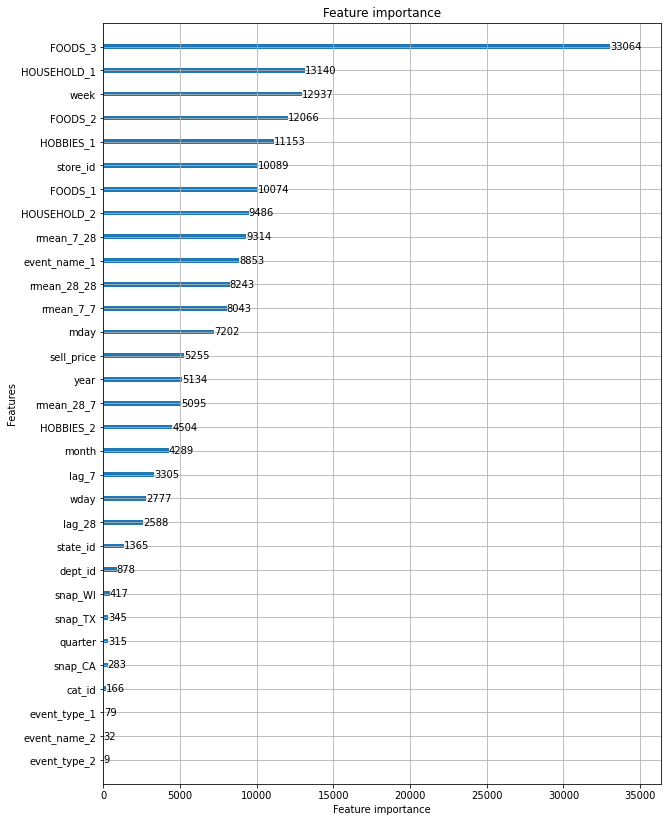

In [20]:
plot_features(m_lgb, (10,14))
